Mencari awal musim hujan di Pulau Kalimantan menggunakan dataset CHIRPS (Climate Hazards infrared Precipitations with Stasions) selama 43 tahun dan mencari rata-rata curah hujan bulanan di Pulau Kalimantan.

In [66]:
#library yang dibutuhkan: xarray, numpy, pandas, matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CHIRPS resolusi 0.25

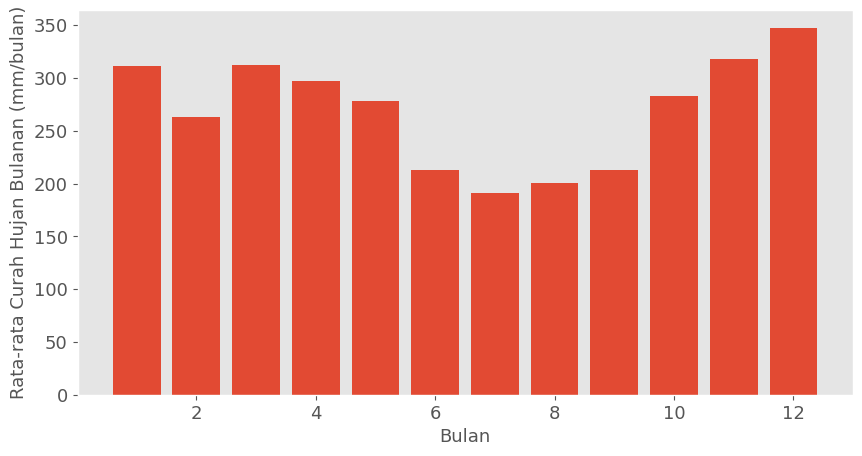

In [31]:
# Membaca file NetCDF
data = xr.open_dataset('CHIRPS_43Tahun.nc')

# Menghitung rata-rata curah hujan di semua grid points
mean_precip = data['precip'][365:11322,:,:].mean(dim=('latitude', 'longitude'))

# Menghitung jumlah curah hujan bulanan
monthly_sum = mean_precip.groupby('time.month').sum(dim='time', skipna=True)
monthly_sum = monthly_sum/30
# Plot grafik batang rata-rata bulanan
plt.figure(figsize=(10, 5))
plt.bar(monthly_sum['month'], monthly_sum)
# plt.title('Rata-Rata Curah Hujan Bulanan Pulau Kalimantan')
plt.xlabel('Bulan',  fontsize=13)
plt.ylabel('Rata-rata Curah Hujan Bulanan (mm/bulan)',  fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(False)
plt.show()

CHIRPS resolusi 0.05

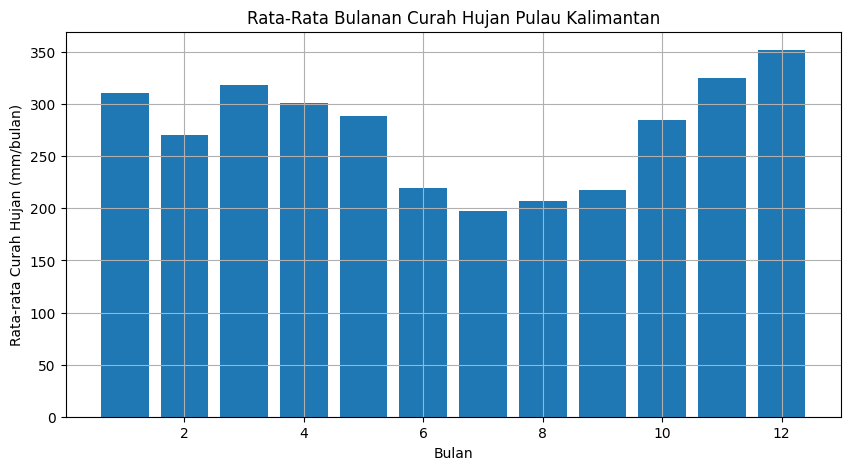

In [3]:
# Membaca file NetCDF
data = xr.open_dataset('CHIRPS_Kalimantan_1981_2023.nc')

# Menghitung rata-rata curah hujan di semua grid points
mean_precip = data['precip'].mean(dim=('latitude', 'longitude'))

# Menghitung jumlah curah hujan bulanan
monthly_sum = mean_precip.groupby('time.month').sum(dim='time', skipna=True)
monthly_sum = monthly_sum/43
# Plot grafik batang rata-rata bulanan
plt.figure(figsize=(10, 5))
plt.bar(monthly_sum['month'], monthly_sum)
plt.title('Rata-Rata Bulanan Curah Hujan Pulau Kalimantan')
plt.xlabel('Bulan')
plt.ylabel('Rata-rata Curah Hujan (mm/bulan)')
plt.grid(True)
plt.show()

AMH menggunakan CHIRPS, perhitungan dilakukan secara berurutan setiap 5 tahun/10 tahun karena devise yang tidak mendukung untuk melakukan secara keseluruahan

In [49]:
data_curah_hujan = xr.open_dataset("Chirps30.nc")  # Ubah "data_curah_hujan.nc" dengan nama file NetCDF Anda
data_curah_hujan['time'] = pd.to_datetime(data_curah_hujan['time']) 
rata_rata_per_tahun = data_curah_hujan['precip'].groupby('time.year').mean(dim='time', skipna=True)
anomali_curah_hujan = data_curah_hujan['precip'] - rata_rata_per_tahun.sel(year=data_curah_hujan['time.year'])
# Hitung akumulasi anomali curah hujan per tahun
akumulasi_anomali_per_tahun = anomali_curah_hujan.groupby('time.year').cumsum(dim='time', skipna=True)
min_index = akumulasi_anomali_per_tahun.groupby('time.year').reduce(np.nanargmin, dim='time')
min_index = min_index.where(min_index != 0)
# Mengubah nilai-nilai di bawah 181 menjadi 182, mengabaikan NaN
min_index = min_index.where((min_index >= 181) | (np.isnan(min_index)), 182)

In [51]:
data_juli_desember = akumulasi_anomali_per_tahun.sel(time=akumulasi_anomali_per_tahun['time.month'].isin([7,8, 9, 10, 11, 12]))
min_index = data_juli_desember.groupby('time.year').reduce(np.nanargmin, dim='time')
min_index = min_index + 181 #dimulai pada bulan juli hari ke- 181 

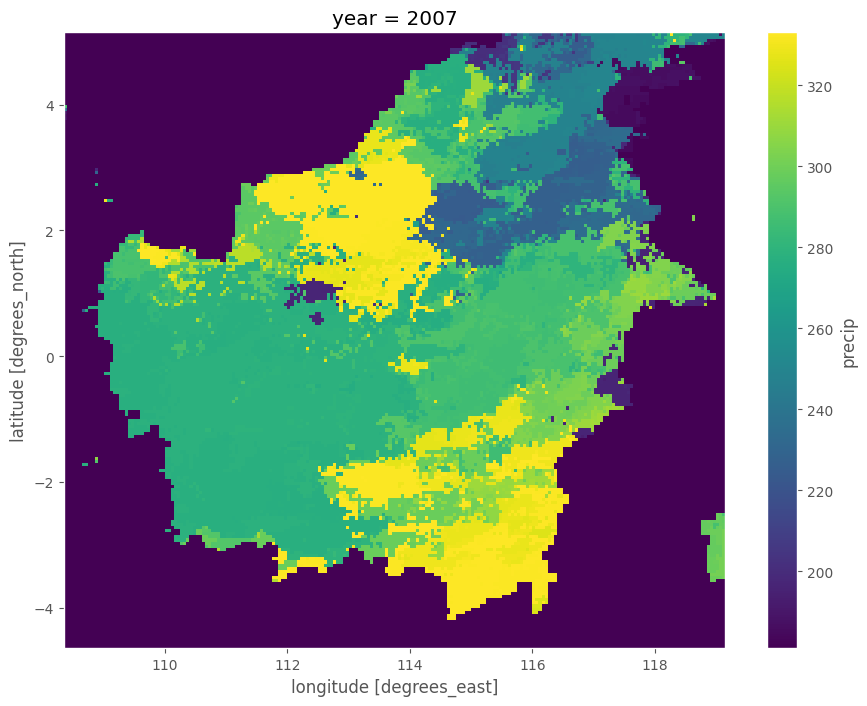

In [55]:
plt.style.use('ggplot')
min_index.isel(year=1).plot(size=8) # hasil akan menunjukkan hasil plot beserta lautan di Pulau Kalimantan

Membuat masking agar lautannya NaN

In [59]:
masking = rata_rata_per_tahun.values
mask = np.isnan(masking)
amh_value = min_index.values
amh_value = amh_value.astype(float)
amh_value[mask] = np.nan

In [1]:
# Convert back to a DataArray
amh_with_nan = xr.DataArray(amh_value, coords=min_index.coords, dims=min_index.dims)

plt.style.use('ggplot')
amh_with_nan.isel(year=1).plot(size=8) # hasil akan menunjukkan hasil plot beserta lautan di Pulau Kalimantan yang sudah dilakukan masking

NameError: name 'xr' is not defined

In [62]:
#save to NetCDF file
amh_with_nan.name = 'AMH'
amh_with_nan.to_netcdf('AMH30.nc')

Menyatukan hasil perhitungan AMH yang telah dilakukan di seluruh Pulau Kalimantan, disimpan dalam file NetCDF.

In [ ]:
# Daftar file yang akan digabungkan
file_paths = ['AMH16Tahun.nc', 'AMH20.nc','AMH25.nc','AMH30.nc','AMHforecastTahun.nc']

# Membaca setiap file menjadi objek Dataset xarray
datasets = [xr.open_dataset(file_path) for file_path in file_paths]

# Menggabungkan dataset menjadi satu dataset tunggal
merged_dataset = xr.merge(datasets)

# Menyimpan dataset yang digabungkan ke dalam file netCDF
merged_dataset.to_netcdf('AMHfull.nc')

# Menutup semua dataset yang terbuka
for dataset in datasets:
    dataset.close()